In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleme Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, f1_score

# Uyarıları kapatma
import warnings
warnings.filterwarnings('ignore')

# Veriyi Yükle
df = pd.read_csv('../data/ai4i2020.csv')
print(f"Veri Seti Boyutu: {df.shape}")

Veri Seti Boyutu: (10000, 14)


In [ ]:
# 1. Encoding: Kategorik 'Type' sütununu sayıya çevirelim
# L -> 0, M -> 1, H -> 2
type_map = {'L': 0, 'M': 1, 'H': 2}
df['Type'] = df['Type'].map(type_map)

# 2. Gereksiz ve Sızıntı Yaratan Sütunları Çıkaralım
# UDI, Product ID -> Kimlik bilgisi, modele girmez.
# TWF, HDF, PWF, OSF, RNF -> Arıza tipleri (Cevap anahtarıdır), modele girmemeli.
drop_cols = ['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

X = df.drop(drop_cols, axis=1)  # Özellikler (Features)
y = df['Machine failure']       # Hedef (Target)

print("Modelde Kullanılacak Özellikler:")
print(X.columns.tolist())

Modelde Kullanılacak Özellikler:
['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [ ]:
# Veriyi Bölme (%80 Train, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ölçeklendirme (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Eğitim Seti Boyutu: (8000, 6)
Test Seti Boyutu: (2000, 6)



--- Baseline Model Performansı ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.64      0.10      0.18        68

    accuracy                           0.97      2000
   macro avg       0.80      0.55      0.58      2000
weighted avg       0.96      0.97      0.96      2000

ROC-AUC Skoru: 0.9003


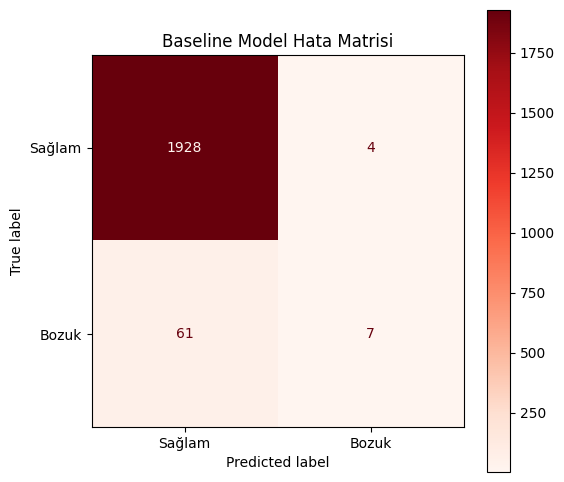

In [ ]:
# Modeli Tanımlama ve Eğitme
# class_weight=None diyoruz çünkü baseline'da dengesizliği bilerek görmezden geliyoruz.
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)


y_pred = baseline_model.predict(X_test_scaled)
y_prob = baseline_model.predict_proba(X_test_scaled)[:, 1] # ROC-AUC için olasılıklar


print("\n--- Baseline Model Performansı ---")
print(classification_report(y_test, y_pred))

# Kritik Metrikler
recall = f1_score(y_test, y_pred) 
roc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Skoru: {roc:.4f}")

# Hata Matrisi (Confusion Matrix) Görselleştirme
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sağlam', 'Bozuk'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Reds', values_format='d', ax=plt.gca())
plt.title('Baseline Model Hata Matrisi')
plt.grid(False)
plt.show()

### Baseline Model Değerlendirmesi

Standart Logistic Regression modeli ile yapılan ilk denemede elde edilen sonuçlar:

* **Accuracy:** %97 (Yanıltıcı derecede yüksek).
* **Recall (Bozuk Sınıfı):** **%10** (Kabul edilemez).
* **Bulgu:** Model, veri setindeki dengesizlikten dolayı ("Sağlam" sınıfı baskın) arızaları tespit etmekte yetersiz kalmıştır. 68 arızanın 61'i kaçırılmıştır (False Negative).

**İyileştirme Stratejisi:**
Bir sonraki aşamada bu sorunu çözmek için:
1.  **Feature Engineering:** Fiziksel ilişkileri (Güç = Tork x Hız) modele tanıtacağız.
2.  **SMOTE:** Azınlık sınıfı (Bozuk) sentetik olarak çoğaltıp dengeyi sağlayacağız.
3.  **Gelişmiş Model:** Lineer model yerine **Random Forest** veya **XGBoost** kullanacağız.